In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/bumpcosmologygwtc3_Mc`


h_plot (generic function with 1 method)

┌ Info: Minimum dN/dm before scaling: 4.289051564296334e-9
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sdnNjb2RlLXJlbW90ZQ==.jl:41
┌ Info: Scale factor: 2.331517784314773e8
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sdnNjb2RlLXJlbW90ZQ==.jl:42
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


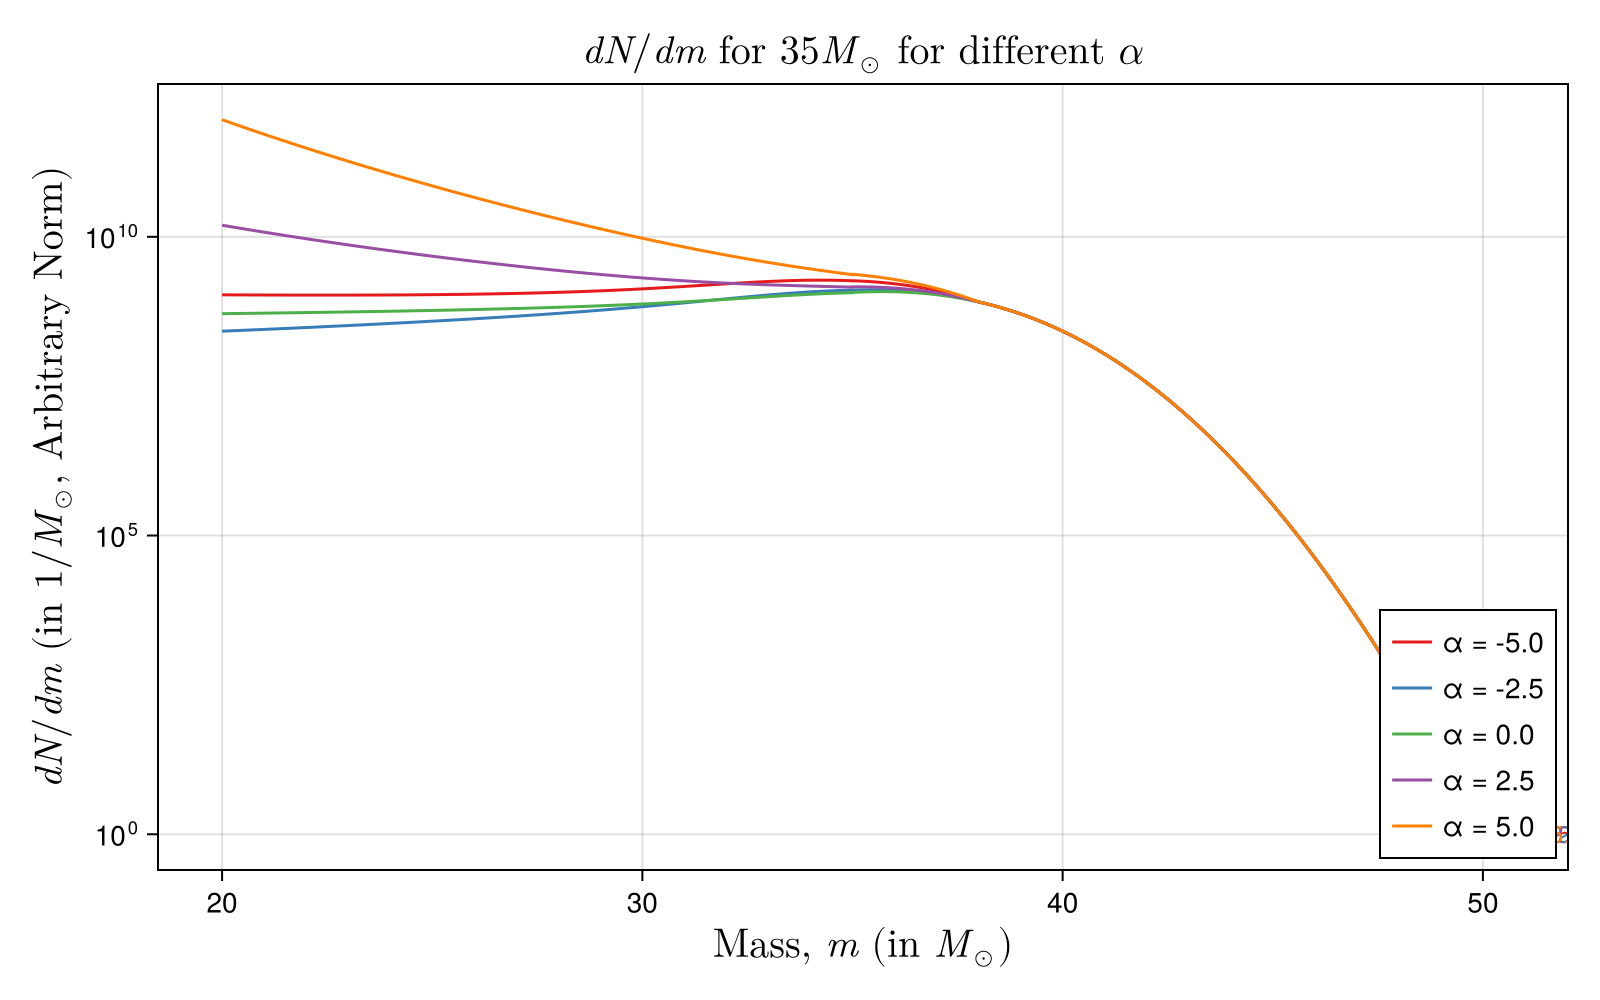

In [2]:
using Colors  # To access color palettes

# Include the log_dNdm function from external file
include("../src/model.jl")

# Fixed parameters
mtr = 35
mbhmax = 38
sigma = 3

# Range of masses
m_vals = 20:0.001:50

# α values from -5 to 5
alpha_vals = range(-5, 5, length=5)

# --- Step 1: Compute all dN/dm values to find minimum ---
all_dNdm = Float64[]

for α in alpha_vals
    for m in m_vals
        val_log = log_dNdm(m, α, mtr, mbhmax, sigma)
        if isfinite(val_log)
            val = 10.0 ^ val_log
            if val > 0
                push!(all_dNdm, val)
            end
        end
    end
end

# Handle case where no valid values were found
if isempty(all_dNdm)
    error("No valid dN/dm values found. Check log_dNdm function output.")
end

# Compute scaling factor to make min value = 1
min_val = minimum(all_dNdm)
scale_factor = 1.0 / min_val

@info "Minimum dN/dm before scaling: $min_val"
@info "Scale factor: $scale_factor"

# --- Step 2: Plot ---
fig = Figure(resolution = (800, 500))

# Use a color-blind friendly palette (ColorBrewer Set1) from Colors
color_palette = [RGB(228/255, 26/255, 28/255),  # Red
                 RGB(55/255, 126/255, 184/255),  # Blue
                 RGB(77/255, 175/255, 74/255),   # Green
                 RGB(152/255, 78/255, 163/255),  # Purple
                 RGB(255/255, 127/255, 0/255)]   # Orange

# Create the plot axis
ax = Axis(fig[1, 1],
          xlabel = L"\mathrm{Mass,}~m~(\mathrm{in}~M_{\odot})",
          ylabel = L"dN/dm~(\mathrm{in}~1/M_{\odot},~\mathrm{Arbitrary~Norm})",
          title = L" dN/dm~\mathrm{for}~35M_{\odot}~\mathrm{for~different}~\alpha",
          xlabelsize=20, 
          ylabelsize=20, 
          titlesize=20,
          yscale = log10)  # Use logarithmic y-axis

# Add the lines with labels for the legend and inline text labels
for (i, α) in enumerate(alpha_vals)
    dNdm_vals = Float64[]

    for m in m_vals
        val_log = log_dNdm(m, α, mtr, mbhmax, sigma)
        if isfinite(val_log)
            val = scale_factor * 10.0 ^ val_log
            push!(dNdm_vals, val > 0 ? val : NaN)
        else
            push!(dNdm_vals, NaN)
        end
    end

    # Plot the curve with a label for the legend, using color-blind friendly palette
    line_obj = lines!(ax, m_vals, dNdm_vals, label="α = $(round(α, digits=2))", color=color_palette[i])

    # Annotate near the end of the curve with inline text
    for i in reverse(eachindex(dNdm_vals))
        if isfinite(dNdm_vals[i])
            x = m_vals[i]
            y = dNdm_vals[i]
            text!(ax,
                  "α = $(round(α, digits=2))",
                  position = (x + 0.5, y),
                  align = (:left, :center),
                  fontsize = 12,
                  color = line_obj.color[])
            break
        end
    end
end

# Display the legend properly outside the plot area
axislegend(ax, position = :rb)  # Position the legend at the right-bottom corner
fig  # Display the figure

In [5]:
using Dierckx
using Colors  # For color palettes

# Include the function
include("../src/model.jl")

# Fixed parameters
log_rhm = -2.5
alphahm = 2.6
mtr = 29.1
mbhmax = 34.3
sigma = 3.3

# Range of masses and alpha
m_vals = 20:0.001:50
alpha_vals = range(-5, 5, length=5)

# Define mgrid and mnorm for keyword args
mgrid = collect(10:0.25:100)
mnorm = 35.0

# Step 1: Compute all values to determine scaling
all_vals = Float64[]

for α in alpha_vals
    for m in m_vals
        val_log = make_combined_log_dNdm(log_rhm, alphahm, α, mtr, mbhmax, sigma; mgrid=mgrid, mnorm=mnorm)
        if isfinite(val_log)
            val = exp(val_log)
            if val > 0
                push!(all_vals, val)
            end
        end
    end
end

# Safety check
if isempty(all_vals)
    error("No valid values from make_combined_log_dNdm.")
end

# Normalize by minimum value
min_val = minimum(all_vals)
scale_factor = 1.0 / min_val

@info "Minimum before scaling: $min_val"
@info "Scale factor: $scale_factor"

# Step 2: Plotting
fig = Figure(resolution = (800, 500))

# Color palette (ColorBrewer Set1)
color_palette = [
    RGB(228/255, 26/255, 28/255),
    RGB(55/255, 126/255, 184/255),
    RGB(77/255, 175/255, 74/255),
    RGB(152/255, 78/255, 163/255),
    RGB(255/255, 127/255, 0/255)
]

# Plot axis
ax = Axis(fig[1, 1],
    xlabel = L"\mathrm{Mass,}~m~(\mathrm{in}~M_{\odot})",
    ylabel = L"\exp(\mathrm{log}~dN/dm)~(\mathrm{Arbitrary~Norm})",
    title = L"\exp(\mathrm{log}~dN/dm)~\mathrm{vs}~m~\mathrm{for~different}~\alpha",
    xlabelsize=20,
    ylabelsize=20,
    titlesize=20,
    yscale=log10
)

# Loop over alpha and plot
for (i, α) in enumerate(alpha_vals)
    vals = Float64[]

    for m in m_vals
        val_log = make_combined_log_dNdm(log_rhm, alphahm, α, mtr, mbhmax, sigma; mgrid=mgrid, mnorm=mnorm)
        if isfinite(val_log)
            val = scale_factor * exp(val_log)
            push!(vals, val > 0 ? val : NaN)
        else
            push!(vals, NaN)
        end
    end

    # Plot curve
    line_obj = lines!(ax, m_vals, vals, label="α = $(round(α, digits=2))", color=color_palette[i])

    # Inline text annotation
    for i in reverse(eachindex(vals))
        if isfinite(vals[i])
            x = m_vals[i]
            y = vals[i]
            text!(ax,
                "α = $(round(α, digits=2))",
                position = (x + 0.5, y),
                align = (:left, :center),
                fontsize = 12,
                color = line_obj.color[])
            break
        end
    end
end

# Show legend
axislegend(ax, position = :rb)
fig  # Display the figure


UndefVarError: UndefVarError: `interp1d` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [3]:
import Pkg
Pkg.add("Dierckx")


   Resolving package versions...
   Installed Dierckx_jll ─ v0.2.0+0
   Installed Dierckx ───── v0.5.4
      Compat entries added for Dierckx
    Updating `~/bumpcosmologygwtc3_Mc/Project.toml`
  [39dd38d3] + Dierckx v0.5.4
    Updating `~/bumpcosmologygwtc3_Mc/Manifest.toml`
  [39dd38d3] + Dierckx v0.5.4
  [cd4c43a9] + Dierckx_jll v0.2.0+0
Precompiling project...
   2257.5 ms  ✓ Dierckx_jll
    815.9 ms  ✓ Dierckx
  2 dependencies successfully precompiled in 18 seconds. 540 already precompiled.


In [6]:
import Pkg
Pkg.status()

Project BumpCosmologyGWTC3 v0.1.0
Status `~/bumpcosmologygwtc3_Mc/Project.toml`
⌃ [0bf59076] AdvancedHMC v0.7.0
  [c7e460c6] ArgParse v1.2.0
  [131c737c] ArviZ v0.12.2
⌃ [13f3f980] CairoMakie v0.13.4
  [5ae59095] Colors v0.13.0
⌃ [76746363] Cosmology v1.0.3
  [a93c6f00] DataFrames v1.7.0
  [8bb1440f] DelimitedFiles v1.9.1
  [39dd38d3] Dierckx v0.5.4
⌃ [0703355e] DimensionalData v0.29.15
⌃ [31c24e10] Distributions v0.25.119
  [1419eebc] GaussianKDEs v0.1.1
  [f67ccb44] HDF5 v0.17.2
⌃ [6a3955dd] ImageFiltering v0.7.9
⌃ [b5cf5a8d] InferenceObjects v0.4.10
  [682c06a0] JSON v0.21.4
  [b964fa9f] LaTeXStrings v1.4.0
  [51a256e2] MCMCChainsStorage v0.1.4
⌃ [da2b9cff] Mooncake v0.4.117
  [85f8d34a] NCDatasets v0.14.7
  [43a3c2be] PairPlots v3.0.1
⌃ [85e3b03c] PolyLog v2.5.1
  [892b8080] PopModels v0.1.0 `https://github.com/farr/PopModels.jl.git#main`
  [33c8b6b6] ProgressLogging v0.1.4
  [276daf66] SpecialFunctions v2.5.1
⌃ [2913bbd2] StatsBase v0.34.4
⌃ [4c63d2b9] StatsFuns v1.4.0
  [bd369af6

┌ Info: Minimum dN/dm before scaling: 0.7468584341404539
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X50sdnNjb2RlLXJlbW90ZQ==.jl:41
┌ Info: Scale factor: 1.338941831929477
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X50sdnNjb2RlLXJlbW90ZQ==.jl:42
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


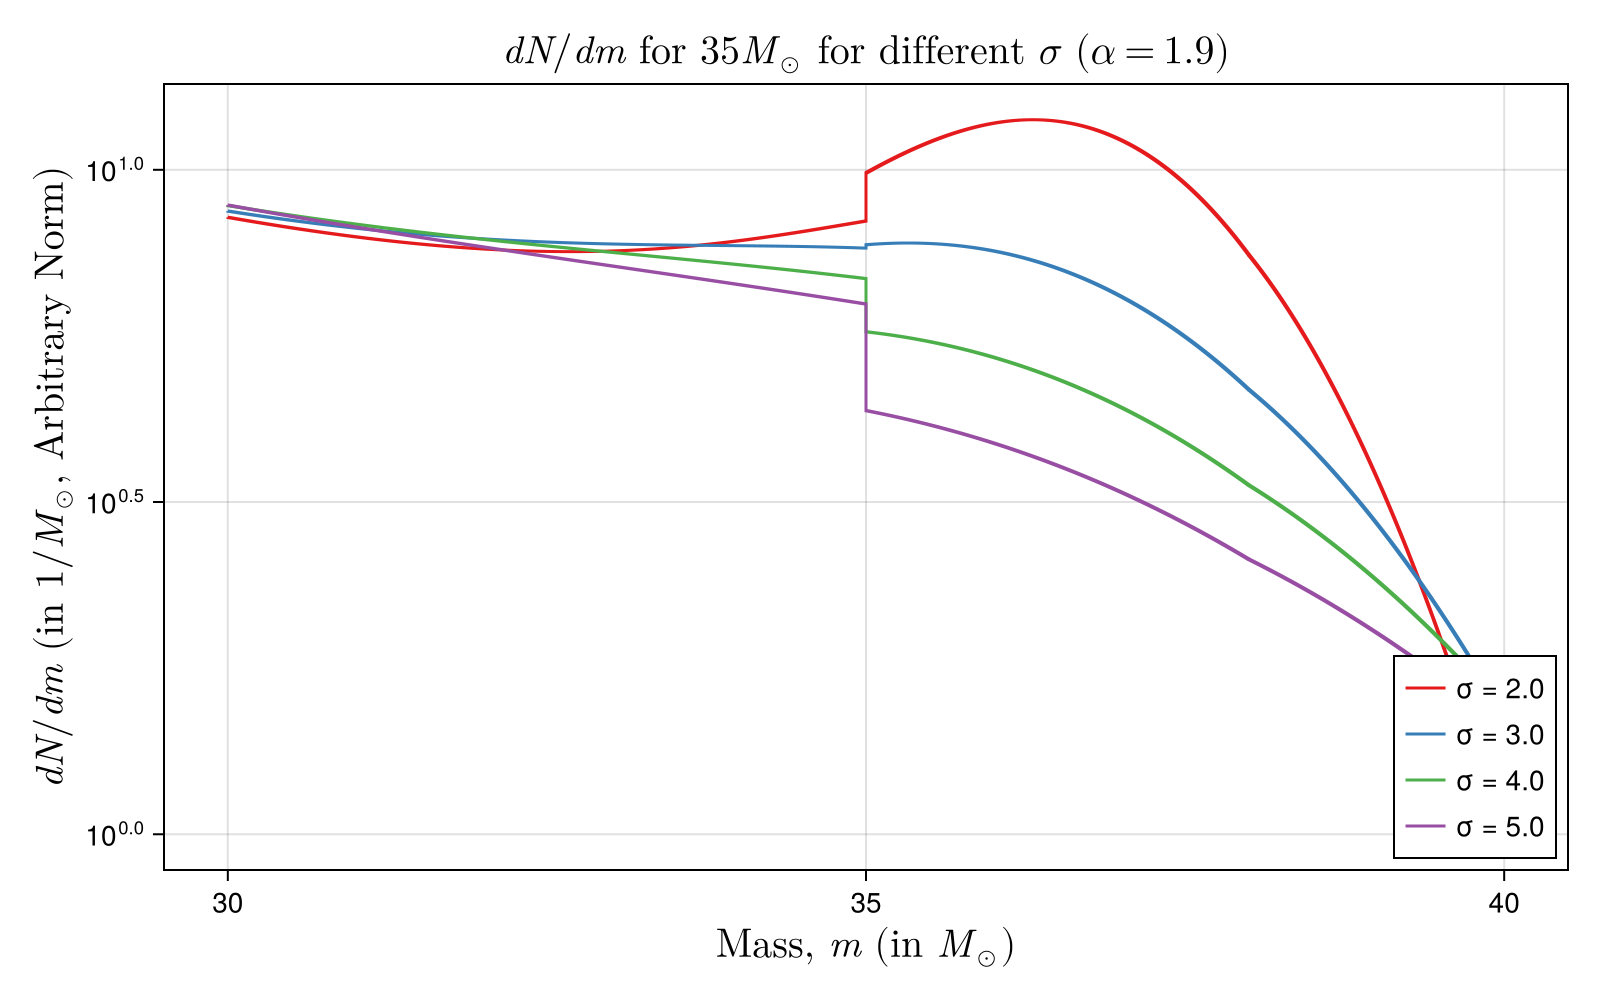

In [3]:
using Colors  # To access color palettes

# Include the log_dNdm function from external file
include("../src/model.jl")

# Fixed parameters
mtr = 35
mbhmax = 38
alpha = 1.9  # Now fixed

# Range of masses
m_vals = 30:0.00001:40

# σ values to vary
sigma_vals = range(2, 5, length=4)

# --- Step 1: Compute all dN/dm values to find minimum ---
all_dNdm = Float64[]

for σ in sigma_vals
    for m in m_vals
        val_log = log_dNdm(m, alpha, mtr, mbhmax, σ)
        if isfinite(val_log)
            val = 10.0 ^ val_log
            if val > 0
                push!(all_dNdm, val)
            end
        end
    end
end

# Handle case where no valid values were found
if isempty(all_dNdm)
    error("No valid dN/dm values found. Check log_dNdm function output.")
end

# Compute scaling factor to make min value = 1
min_val = minimum(all_dNdm)
scale_factor = 1.0 / min_val

@info "Minimum dN/dm before scaling: $min_val"
@info "Scale factor: $scale_factor"

# --- Step 2: Plot ---
fig = Figure(resolution = (800, 500))

# Use a color-blind friendly palette (ColorBrewer Set1) from Colors
color_palette = [RGB(228/255, 26/255, 28/255),  # Red
                 RGB(55/255, 126/255, 184/255),  # Blue
                 RGB(77/255, 175/255, 74/255),   # Green
                 RGB(152/255, 78/255, 163/255),  # Purple
                 RGB(255/255, 127/255, 0/255)]   # Orange

# Create the plot axis
ax = Axis(fig[1, 1],
          xlabel = L"\mathrm{Mass,}~m~(\mathrm{in}~M_{\odot})",
          ylabel = L"dN/dm~(\mathrm{in}~1/M_{\odot},~\mathrm{Arbitrary~Norm})",
          title = L" dN/dm~\mathrm{for}~35M_{\odot}~\mathrm{for~different}~\sigma~(\alpha=1.9)",
          xlabelsize=20, 
          ylabelsize=20, 
          titlesize=20,
          yscale = log10)  # Use logarithmic y-axis

# Add the lines with labels for the legend and inline text labels
for (i, σ) in enumerate(sigma_vals)
    dNdm_vals = Float64[]

    for m in m_vals
        val_log = log_dNdm(m, alpha, mtr, mbhmax, σ)
        if isfinite(val_log)
            val = scale_factor * 10.0 ^ val_log
            push!(dNdm_vals, val > 0 ? val : NaN)
        else
            push!(dNdm_vals, NaN)
        end
    end

    # Plot the curve with a label for the legend, using color-blind friendly palette
    line_obj = lines!(ax, m_vals, dNdm_vals, label="σ = $(round(σ, digits=2))", color=color_palette[i])
end

# Display the legend properly outside the plot area
axislegend(ax, position = :rb)  # Position the legend at the right-bottom corner
fig  # Display the figure


In [4]:
import Pkg
Pkg.rm("KernelDensity")

    Updating `~/bumpcosmologygwtc3_Mc/Project.toml`
  [5ab0869b] - KernelDensity v0.6.9
  No Changes to `~/bumpcosmologygwtc3_Mc/Manifest.toml`


In [28]:
using Colors  # For color-blind-friendly palette
using CairoMakie  # Or GLMakie

# Include the log_dNdm function from external file
include("../src/model.jl")

# Fixed parameters
mbhmax = 38
sigma = 3
alpha = 1.9  # Fixed α

# Mass range
m_vals = 20:0.001:50

# Mtr values (filtered to satisfy mtr < mbhmax)
mtr_vals = filter(mtr -> mtr < mbhmax, 32:5:45)

# --- Step 1: Compute all dN/dm values to find minimum ---
all_dNdm = Float64[]

for mtr in mtr_vals
    for m in m_vals
        val_log = try
            log_dNdm(m, alpha, mtr, mbhmax, sigma)
        catch
            NaN
        end
        if isfinite(val_log)
            val = 10.0 ^ val_log
            if val > 0
                push!(all_dNdm, val)
            end
        end
    end
end

if isempty(all_dNdm)
    error("No valid dN/dm values found. Check log_dNdm function output.")
end

# Scale so that minimum is 1
min_val = minimum(all_dNdm)
scale_factor = 1.0 / min_val

@info "Minimum dN/dm before scaling: $min_val"
@info "Scale factor: $scale_factor"

# --- Step 2: Plot ---
fig = Figure(resolution = (800, 500))

# Color-blind-friendly palette
color_palette = [
    RGB(228/255, 26/255, 28/255),
    RGB(55/255, 126/255, 184/255),
    RGB(77/255, 175/255, 74/255),
    RGB(152/255, 78/255, 163/255),
    RGB(255/255, 127/255, 0/255)
]

ax = Axis(fig[1, 1],
    xlabel = L"\mathrm{Mass,}~m~(\mathrm{in}~M_{\odot})",
    ylabel = L"dN/dm~(\mathrm{in}~1/M_{\odot},~\mathrm{Arbitrary~Norm})",
    title  = L"dN/dm~\mathrm{for~fixed}~\alpha=1.9~\mathrm{and~varying}~M_{\mathrm{tr}}<M_{\mathrm{BH,max}}",
    xlabelsize = 20,
    ylabelsize = 20,
    titlesize = 20,
    yscale = log10
)

for (i, mtr) in enumerate(mtr_vals)
    dNdm_vals = Float64[]

    for m in m_vals
        val_log = try
            log_dNdm(m, alpha, mtr, mbhmax, sigma)
        catch
            NaN
        end

        if isfinite(val_log)
            val = scale_factor * 10.0 ^ val_log
            push!(dNdm_vals, val > 0 ? val : NaN)
        else
            push!(dNdm_vals, NaN)
        end
    end

    line_obj = lines!(ax, m_vals, dNdm_vals, label = "Mtr = $(mtr)", color = color_palette[i])

    for j in reverse(eachindex(dNdm_vals))
        if isfinite(dNdm_vals[j])
            x = m_vals[j]
            y = dNdm_vals[j]
            text!(ax,
                "Mtr = $(mtr)",
                position = (x + 0.5, y),
                align = (:left, :center),
                fontsize = 12,
                color = line_obj.color[])
            break
        end
    end
end

axislegend(ax, position = :rb)
fig


┌ Info: Minimum dN/dm before scaling: 1.2107517993932594e-9
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X51sdnNjb2RlLXJlbW90ZQ==.jl:45
┌ Info: Scale factor: 8.259331107342786e8
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X51sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


In [26]:
using Colors  # For color-blind-friendly palette
using CairoMakie  # Or GLMakie

# Include the log_dNdm function from external file
include("../src/model.jl")

# Fixed parameters
mbhmax = 51
sigma = 3
alpha = 1.9  # ← FIXED α value here

# Mass range
m_vals = 20:0.001:50

# Mtr values (to vary)
mtr_vals = 32:5:40

# --- Step 1: Compute all dN/dm values to find minimum ---
all_dNdm = Float64[]

for mtr in mtr_vals
    for m in m_vals
        val_log = try
            log_dNdm(m, alpha, mtr, mbhmax, sigma)  # use α = 1.9
        catch
            NaN
        end
        if isfinite(val_log)
            val = 10.0 ^ val_log
            if val > 0
                push!(all_dNdm, val)
            end
        end
    end
end

# Handle case where no valid values were found
if isempty(all_dNdm)
    error("No valid dN/dm values found. Check log_dNdm function output.")
end

# Compute scaling factor to make min value = 1
min_val = minimum(all_dNdm)
scale_factor = 1.0 / min_val

@info "Minimum dN/dm before scaling: $min_val"
@info "Scale factor: $scale_factor"

# --- Step 2: Plot ---
fig = Figure(resolution = (800, 500))

# Color-blind-friendly palette (ColorBrewer Set1)
color_palette = [
    RGB(228/255, 26/255, 28/255),  # Red
    RGB(55/255, 126/255, 184/255),  # Blue
    RGB(77/255, 175/255, 74/255),   # Green
    RGB(152/255, 78/255, 163/255),  # Purple
    RGB(255/255, 127/255, 0/255)    # Orange
]

# Axis
ax = Axis(fig[1, 1],
    xlabel = L"\mathrm{Mass,}~m~(\mathrm{in}~M_{\odot})",
    ylabel = L"dN/dm~(\mathrm{in}~1/M_{\odot},~\mathrm{Arbitrary~Norm})",
    title  = L"dN/dm~\mathrm{for~fixed}~\alpha=1.9~\mathrm{and~varying}~M_{\mathrm{tr}}",
    xlabelsize = 20,
    ylabelsize = 20,
    titlesize = 20,
    yscale = log10
)

# Plot curves
for (i, mtr) in enumerate(mtr_vals)
    dNdm_vals = Float64[]

    for m in m_vals
        val_log = try
            log_dNdm(m, alpha, mtr, mbhmax, sigma)
        catch
            NaN
        end

        if isfinite(val_log)
            val = scale_factor * 10.0 ^ val_log
            push!(dNdm_vals, val > 0 ? val : NaN)
        else
            push!(dNdm_vals, NaN)
        end
    end

    # Plot line
    line_obj = lines!(ax, m_vals, dNdm_vals, label = "Mtr = $(mtr)", color = color_palette[i])

    # Annotate curve
    for j in reverse(eachindex(dNdm_vals))
        if isfinite(dNdm_vals[j])
            x = m_vals[j]
            y = dNdm_vals[j]
            text!(ax,
                "Mtr = $(mtr)",
                position = (x + 0.5, y),
                align = (:left, :center),
                fontsize = 12,
                color = line_obj.color[])
            break
        end
    end
end

# Add legend
axislegend(ax, position = :rb)

# Display figure
fig


┌ Info: Minimum dN/dm before scaling: 17.121627103648592
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X42sdnNjb2RlLXJlbW90ZQ==.jl:46
┌ Info: Scale factor: 0.05840566401466024
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X42sdnNjb2RlLXJlbW90ZQ==.jl:47
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


In [39]:
using HDF5
using Random
using Statistics
using CairoMakie
using Colors  # for RGBAf

# Define color matching Matplotlib's '#1f78b4' with 20% opacity
trace_color = RGBAf(0.121, 0.47, 0.705, 0.2)

# Load AR results properly into variables
m1s, dR_dlnm1s = h5open("/mnt/home/sroy1/ar_lnm1_q_summary.hdf", "r") do file
    read(file["posterior/m1s"]), read(file["posterior/dR_dlnm1s"])
end

# Check that data loaded
@assert m1s !== nothing "Failed to load m1s"
@assert dR_dlnm1s !== nothing "Failed to load dR_dlnm1s"

# Reshape the dR_dlnm1s matrix so that it matches the length of m1s
# dR_dlnm1s needs to be transposed to have 3556 rows (for m1s) and 4500 samples (columns)
dR_dlnm1s = transpose(dR_dlnm1s)

# Check that the reshaped dimensions are now correct
@assert size(dR_dlnm1s, 1) == length(m1s) "dR_dlnm1s should have 3556 rows"
@assert size(dR_dlnm1s, 2) == 4500 "dR_dlnm1s should have 4500 columns"

# Plotting
nsamples = size(dR_dlnm1s, 2)
inds = sample(1:nsamples, 500; replace=false)

# Compute statistics
median_vals = mapslices(median, dR_dlnm1s; dims=2)[:]
q05 = mapslices(x -> quantile(x, 0.05), dR_dlnm1s; dims=2)[:]
q95 = mapslices(x -> quantile(x, 0.95), dR_dlnm1s; dims=2)[:]

# Start figure
f = Figure(resolution=(1000, 400))
ax = Axis(f[1, 1],
    xscale=log10,
    yscale=log10,
    xticks=(log10.([20, 50]), ["20", "50"]),  # Update x-axis to show [20, 50]
    xlabel="Mass of the Heavier Object (\$M_\\odot\$)",
    ylabel="BBH Merger Rate (\$\\mathrm{Gpc}^{-3}\\,\\mathrm{yr}^{-1}\$)",
    xticklabelsize=14,
    yticklabelsize=14,
    limits=(20, 50, 1e-2, 3e3)  # Set x-limits to [20, 50]
)

# Enable grids on both x and y axes
ax.xgridvisible = true
ax.ygridvisible = true

# Set grid line style and width
ax.xgridstyle = :dash
ax.ygridstyle = :dash
ax.xgridwidth = 0.7
ax.ygridwidth = 0.7

# Plot random traces
for i in inds
    lines!(ax, m1s, dR_dlnm1s[:, i], color=trace_color, linewidth=0.1)
end

# Plot summary stats
lines!(ax, m1s, median_vals, color=:black)
lines!(ax, m1s, q05, color=:black, linewidth=0.3)
lines!(ax, m1s, q95, color=:black, linewidth=0.3)

# Hide spines
hidespines!(ax)

# Display figure
f


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


In [28]:
@show size(m1s)
@show size(dR_dlnm1s)

size(m1s) = (3556,)
size(dR_dlnm1s) = (4500, 3556)


(4500, 3556)

# Load Events

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    o1o2o3_sensitivity_file::String
end

system = :rusty
if system == :rusty
    paths = Paths(
        "/mnt/home/ccalvk/ceph/GWTC-2.1", 
        "/mnt/home/ccalvk/ceph/GWTC-3", 
        "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
        "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
    )
elseif system == :wmflaptop
    paths = Paths(
        "/Users/wfarr/Research/gwtc-2.1",
        "/Users/wfarr/Research/o3b_data/PE",
        "/Users/wfarr/Research/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
        "/Users/wfarr/Research/o3b_data/O1O2O3-Sensitivity/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5"
    )
end

Paths("/mnt/home/ccalvk/ceph/GWTC-2.1", "/mnt/home/ccalvk/ceph/GWTC-3", "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json", "/mnt/home/ccalvk/ceph/sensitivity-estimates/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5")

In [3]:
## Load PE
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)
all_pe[:, :prior_logwt_m1qzchie] = li_nocosmo_prior_logwt_m1qzchie(all_pe)
pe_table = far_cut(chirp_mass_cut(all_pe))

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/bumpcosmologygwtc3_Mc/src/load.jl:26


2209551×49 DataFrame
     Row │ spin_2y      dec         chirp_mass  redshift   theta_jn   ra       ⋯
         │ Float64      Float64     Float64     Float64    Float64    Float64  ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  0.0157482   -1.2029        30.9684  0.0968552  2.77079    1.28323  ⋯
       2 │  0.306186    -1.17447       31.6976  0.0858721  2.58701    1.12687
       3 │ -0.281979    -1.20404       29.1559  0.0984072  2.65664    2.28386
       4 │ -0.0257892   -1.28148       29.4337  0.0788087  2.46328    1.66579
       5 │ -0.615255    -1.22545       28.3426  0.093687   2.78603    2.18355  ⋯
       6 │  0.0101604   -1.2815        30.2896  0.105684   2.71688    1.89592
       7 │ -0.0143139   -1.22618       30.8565  0.120825   2.83255    2.33255
       8 │ -0.00522301  -1.25144       29.8868  0.118836   3.04766    2.17208
    ⋮    │      ⋮           ⋮           ⋮           ⋮          ⋮          ⋮    ⋱
 2209545 │ -0.0640401   -0.185993      32.4347  0.185204   0.867098   0.045988 ⋯
 2209546 │  0.0609365   -0.227942      33.2508  0.245105   0.688354   0.059579
 2209547 │ -0.0600332   -0.113386      36.5761  0.26245    0.58703    0.029710
 2209548 │ -0.235254    -0.275099      30.2488  0.240664   0.538099   0.075851
 2209549 │ -0.128996    -0.10511       32.0233  0.241037   0.180832   0.051778 ⋯
 2209550 │  0.00895406  -0.142332      36.9234  0.271176   0.33938    0.058688
 2209551 │ -0.457297    -0.0432304     32.7125  0.224792   0.392916   0.015391
                                             44 columns and 2209536 rows omitted

In [4]:
## Check number of events
n0p1, n0p5, n0p9 = length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.1)), :gwname)), length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.5)), :gwname)), length(groupby(far_cut(chirp_mass_cut(all_pe, thresh=0.9)), :gwname))
@info "N(p > 0.1) = $(n0p1); N(p > 0.5) = $(n0p5); N(p > 0.9) = $(n0p9)"

┌ Info: N(p > 0.1) = 46; N(p > 0.5) = 43; N(p > 0.9) = 39
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sdnNjb2RlLXJlbW90ZQ==.jl:3


In [5]:
# Just plot the 0.5 sample:
pe = far_cut(chirp_mass_cut(all_pe, thresh=0.5))

2328122×49 DataFrame
     Row │ spin_2y      dec         chirp_mass  redshift   theta_jn   ra       ⋯
         │ Float64      Float64     Float64     Float64    Float64    Float64  ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  0.0157482   -1.2029        30.9684  0.0968552  2.77079    1.28323  ⋯
       2 │  0.306186    -1.17447       31.6976  0.0858721  2.58701    1.12687
       3 │ -0.281979    -1.20404       29.1559  0.0984072  2.65664    2.28386
       4 │ -0.0257892   -1.28148       29.4337  0.0788087  2.46328    1.66579
       5 │ -0.615255    -1.22545       28.3426  0.093687   2.78603    2.18355  ⋯
       6 │  0.0101604   -1.2815        30.2896  0.105684   2.71688    1.89592
       7 │ -0.0143139   -1.22618       30.8565  0.120825   2.83255    2.33255
       8 │ -0.00522301  -1.25144       29.8868  0.118836   3.04766    2.17208
    ⋮    │      ⋮           ⋮           ⋮           ⋮          ⋮          ⋮    ⋱
 2328116 │ -0.0640401   -0.185993      32.4347  0.185204   0.867098   0.045988 ⋯
 2328117 │  0.0609365   -0.227942      33.2508  0.245105   0.688354   0.059579
 2328118 │ -0.0600332   -0.113386      36.5761  0.26245    0.58703    0.029710
 2328119 │ -0.235254    -0.275099      30.2488  0.240664   0.538099   0.075851
 2328120 │ -0.128996    -0.10511       32.0233  0.241037   0.180832   0.051778 ⋯
 2328121 │  0.00895406  -0.142332      36.9234  0.271176   0.33938    0.058688
 2328122 │ -0.457297    -0.0432304     32.7125  0.224792   0.392916   0.015391
                                             44 columns and 2328107 rows omitted

# Load Trace

In [6]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.29, minimum Neff_sel = 919.9, 4*Nobs = 172
└ @ Main /mnt/home/sroy1/bumpcosmologygwtc3_Mc/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sdnNjb2RlLXJlbW90ZQ==.jl:4


In [7]:
trace = trace_samples_0p5

InferenceData with groups:
  > posterior
  > sample_stats

# $q-\chi_\mathrm{eff}$ Plots

## PE Contours

In [12]:
## q-chi_eff contour plot
pe_grouped = groupby(pe, :gwname)
n = length(pe_grouped)

cs = categorical_palette(n)
rng = Random.Xoshiro(0xaf91589a0f32ada4)

f = Figure()
a = Axis(f[1,1], xlabel=L"\chi_\mathrm{eff}", ylabel=L"q")

@progress for (c, evt) in zip(cs, pe_grouped)
    inds = rand(rng, 1:size(evt, 1), 256)
    e = evt[inds, :]
    kdecontour!(a, e.chi_eff, e.mass_ratio, color=c, levels=[0.1])
end
f

## Pop Plots

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /mnt/home/sroy1/.julia/packages/Makie/6KcTF/src/scenes.jl:238


Standard deviation of dNdchi_p10: 3.8363715102080924
Standard deviation of dNdchi_median: 6.199795472850886
Standard deviation of dNdchi_p90: 10.229455197806667


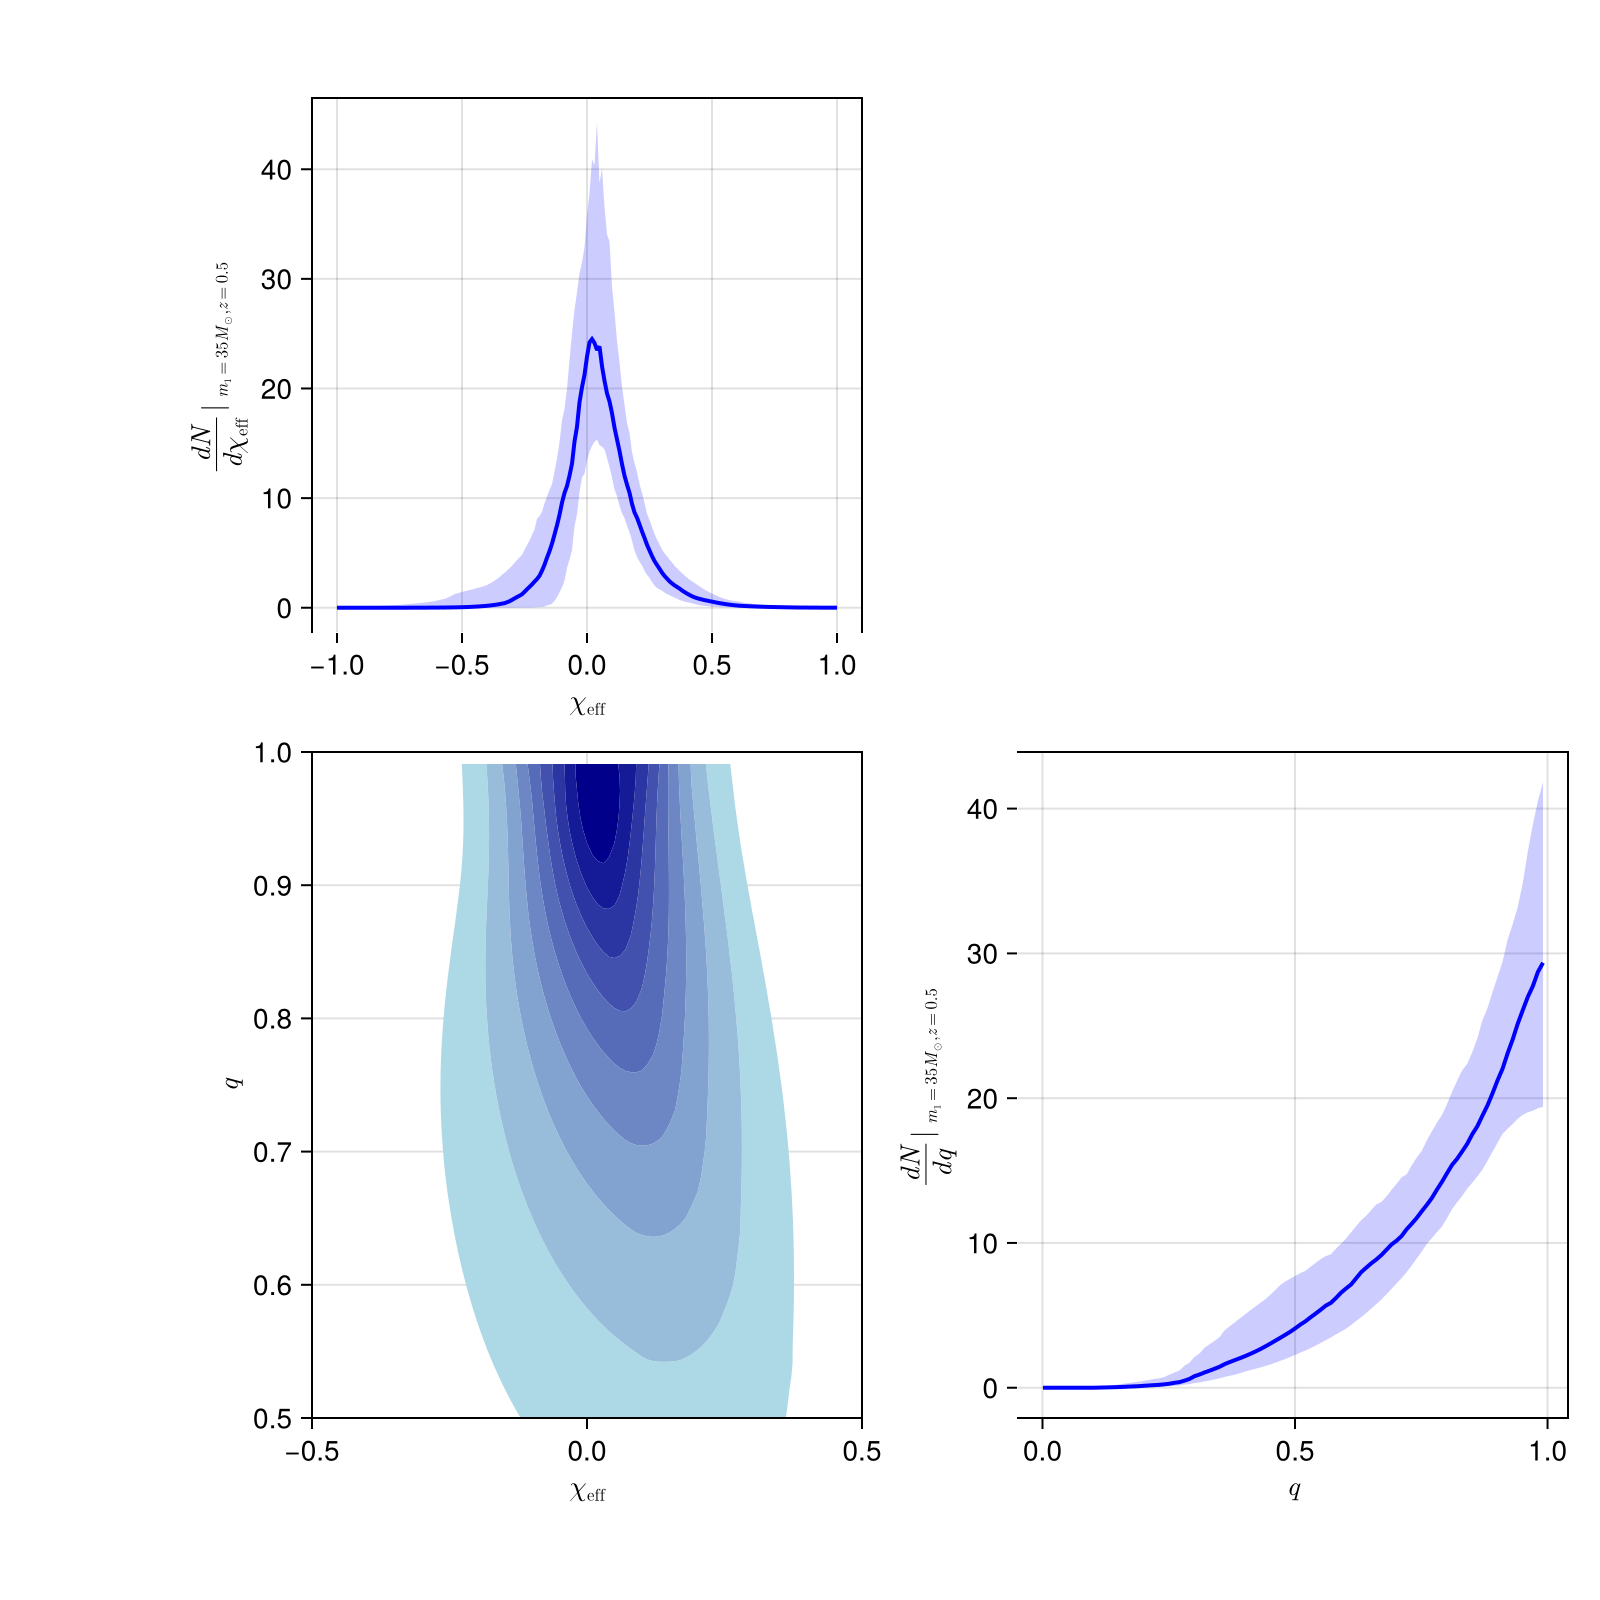

In [16]:
f = q_chieff_corner_plot(trace)
#save(joinpath(@__DIR__, "..", "figures", "q_chieff.pdf"), f)
f